---
title: "Judging Wine Prices: Training Data (Part 1)"
description: "Is $20 a good price for this bottle?"
author:
  - name: Stephen Ro
    url: https://royourboat.github.io/
date: 07-10-2023
categories: [Python, JSON, BERT, NLP] # self-defined categories
citation: 
  url: https://royourboat.github.io/posts/2023-07-10-price-sentiment/
image: cover.png
draft: false # setting this to `true` will prevent your post from appearing on your listing page until you're ready!
footnotes-hover: true
format: 
  html:
    code-fold: true
    code-overflow: wrap
    toc: true
    code-block-background: true
    code-block-border-left: "#31BAE9"
number-sections: false
highlight-style: github

markdown:
  wrap: 72
---

This is part one of a series where I train a machine learning model on price sentiment.

In part one, I'll go over:

- The distribution of 5,500 price sentiment reviews (Positive, Neutral, Negative, Don't know). 
- Metric requirements for a "good" or desirable recommender.
- Two NLP strategies: bag-of-words and using sentence embeddings with SBERT.

First, here's a motivation for why I did any of this.

# Motivation

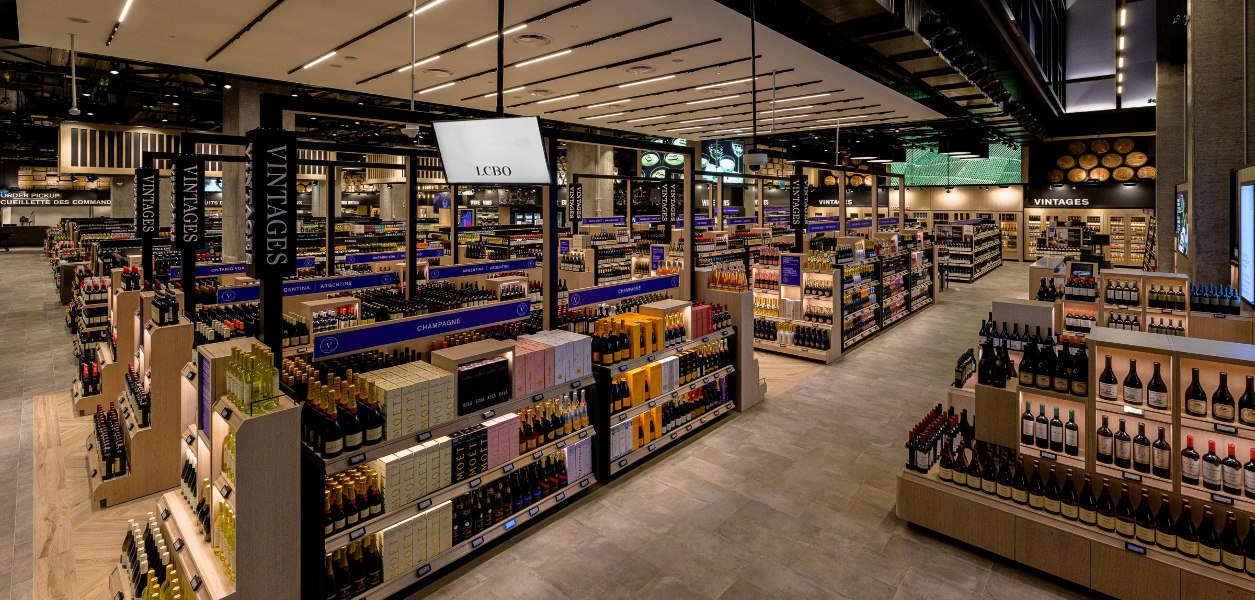

This is a picture of an LCBO store in Toronto, Canada. All of the wines are exciting to look at and I want to try some! But, how will I know what's good? There's thousands to choose from! Looking on their app, I found two things:

- The interesting bottles had very few reviews
- I confirmed that I do not know much about wine, so reviews aren't all that helpful

I gave up and asked an LCBO wine guide for recommendations. Both of the bottles recommended were horrendous. The bite to my wallet hurt too. 

An incredibly popular wine app, Vivino, is great at identifying wines using their image recognition software. But, I'm not going to stand around all day taking pictures of wine. It is good at filtering out which bottles have under 4-stars. But, I would also like a good deal after my expensive experience. 

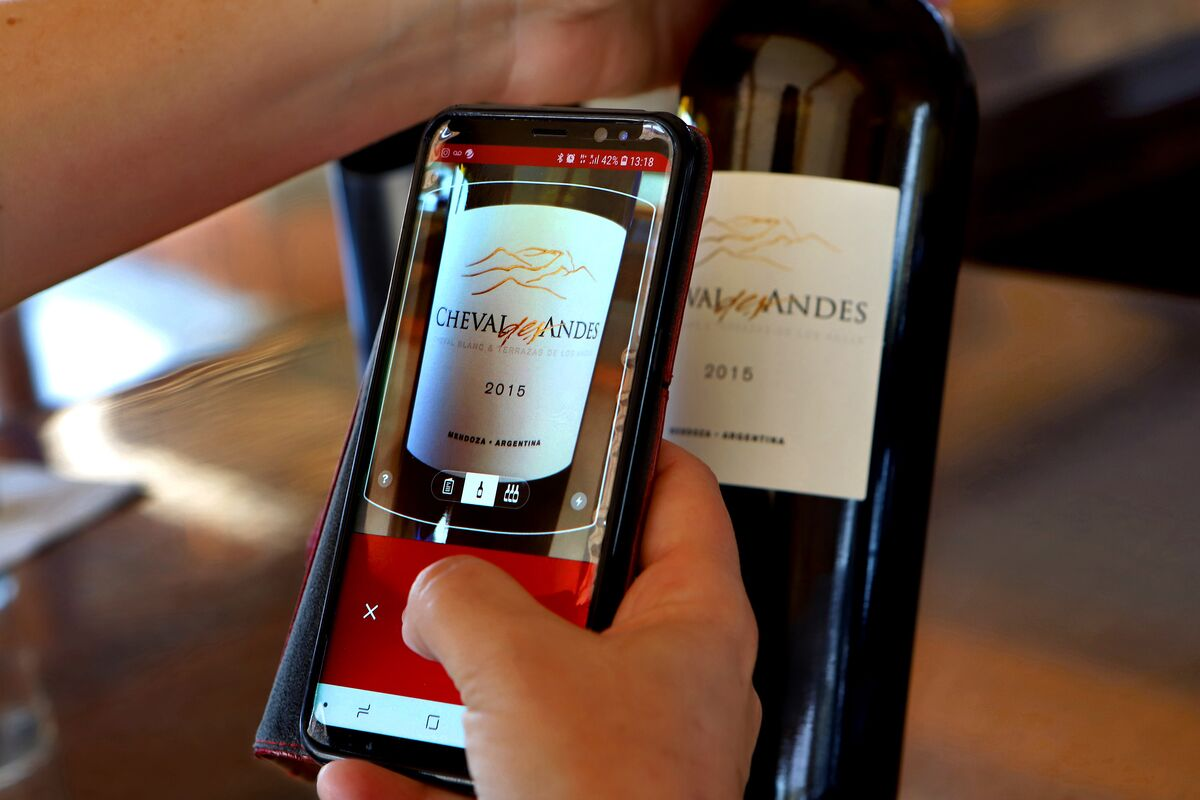

<span style="font-size:20pt" aligh="center">"You have to spend a little to discover."</span> 

My goal is to increase the odds of finding well-priced discoveries. Using Natural Language Processing and machine learning techniques, I identify wines at the LCBO with high price-sentiments based on Vivino reviews. Here's how I did it.

# What is price-sentiment data?

I noticed about 0.5% (~1 in 200) of reviews on Vivino contain (1) the price a user paid, and (2) the sentiment for that price. Samples of reviews with "price-sentiment" are shown in the diagram below. 

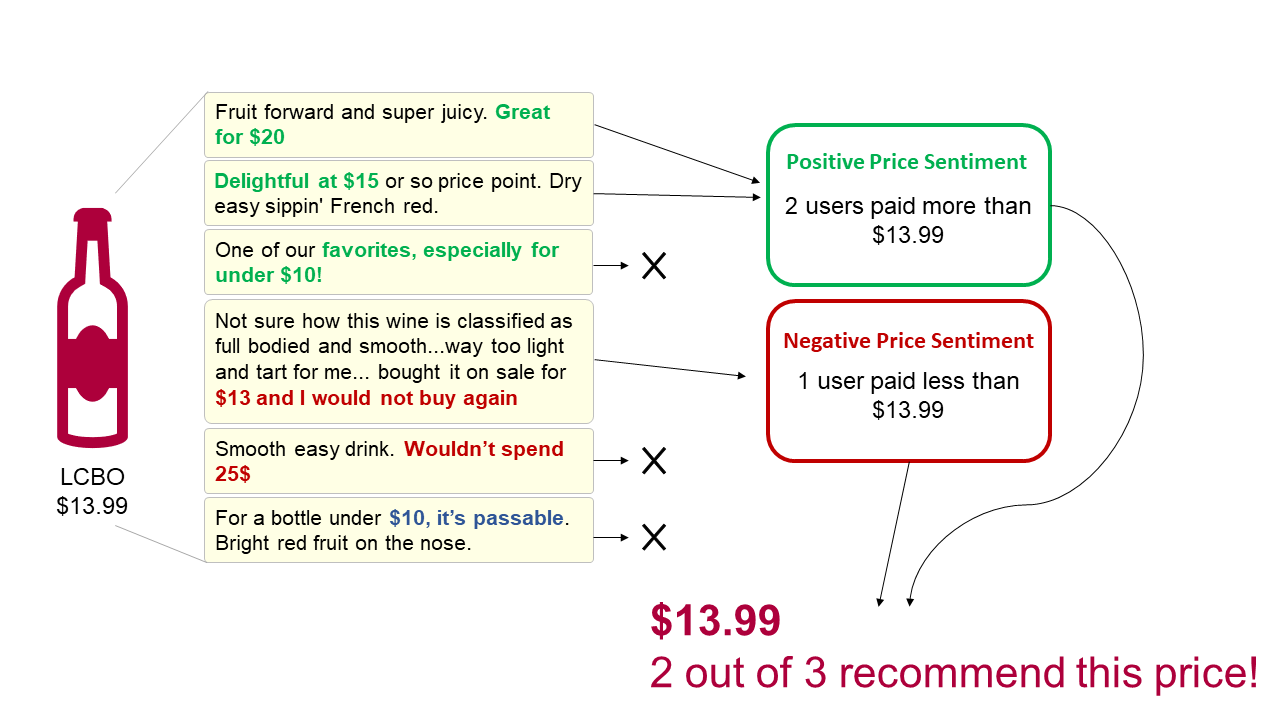


I realized that with enough price-sentiment reviews, I could estimate whether a bottle's price was "good" based on what everyone else has paid. For example, the bottle above sells for $13.99 and found users who:

- paid <span style="font-weight:bold">more</span> than $13.99 and <span style="color:green;">liked</span> the price, and
- paid <span style="font-weight:bold">less</span> than $13.99 and <span style="color:red;">disliked</span> the price

There are several dozens of bottles at the LCBO with 10k to 100k+ reviews on vivino. That translates into roughly 50 to 500 price-sentiment reviews. That is quite a lot of data per bottle and sufficient to inform a recommendation algorithm. So, let's make one!

# 1. Scraping Wines and Reviews

I created a bot on GitHub Actions to scrape all of LCBO's 9k+ wine data. The data is uploaded to my postgreSQL database. For more details, check out these blogs:

I matched the LCBO wines to wines on Vivino using their explore API. The API returns several candidate results ranked by similarity. However, sometimes the first result is not correct due to their being numerous wines and vintages with similar names. For example, Mike Weir Chardonnay, Mike Weir Limited Edition Barrel Fermented Chardonnay, Limited Edition 4 Barrel Chardonnay. A simple verification for the matches is to minimize the intersection of words contained in two wine names. 

After that, I obtained 6M reviews from Vivino for wines available at the LCBO using Vivino's API. I look into the reviews [here](../2023-07-06-vivino-part1/). 

# 2: Selecting Reviews with Prices

Reviews containing a price are identified by looking for dollar signs immediately adjacent to an integer or flow. For example, "\$50", "39.99\$". 

In [1]:
#| code-summary: "Code: Use regex for price (integer) amount"
import math
import re

def getPrice(text):
    if not text: # Reject empty strings
        return None
    
    # Return text if dollar sign is head: E.g., "Paid $10 bucks" --> "$10"
    textLeadDollarSign = re.search(r'\w*\$\d+(?:\.\d+)?\w*', text) 

    if textLeadDollarSign:
        textPrice = textLeadDollarSign
    else:
    # Return text if dollar sign is tail: E.g., "Paid 10$ bucks" --> "10$"
        textTailDollarSign = re.search(r'\w*\d+(?:\.\d+)?\$\w*', text) 
        textPrice = textTailDollarSign

    # Reject no results
    if not textPrice:
        return None

    # Get float representing price.
    textPrice = textPrice.group(0)
    textPrice = re.search(r'\d+(?:\.\d+)?', textPrice).group(0) 
    textPrice = textPrice.replace('$','')    # Delete '$' sign
    price = int(math.ceil(float(textPrice)))  # Round up to nearest dollar
    return price

This rule-based filter found approximately 55k reviews contain prices. 

In [2]:
#| echo: false
#| tbl-colwidths: [5,95]
#| tbl-cap: "Samples of reviews with prices"
import pandas as pd
from IPython.display import Markdown
from tabulate import tabulate

dirIn = "D:\\vivino_data\\survey_results\\"
filename = dirIn + "unlabelled_surveys.csv"
df = pd.read_csv('sample_unlabelled_reviews.csv', encoding="utf-8-sig")
Markdown(tabulate(
  list(zip(df['rating'],  df['reviews'])), 
  headers=[ "Rating", "Review" ]
))

  Rating  Review
--------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
     2    Just a simple quaffer. Not much going on here at all. Have with salads or Thai food. Good with take-out sushi. Decent value at $11 but not textbook Viognier.
     3.5  It’s very popular, but not my cup of vino given the “juicy” style; as opposed to tannic big cabs that I prefer. All in all would definitely drink again but only buy it for myself at a sub $50 pp
     3.5  Very nice.  Much more expensive in a restaurant.   If you can find it for $15... buy some.
     4    Tasted w/Nat at Russ's Wine & Food Experience 2018 (Reserve Room selection) at Embassy Suites 2/23/18. 100% Cabernet Sauvignon. Well structured with complex aromas of plum jam, green pepper, raising, tobacco and touch of oak. Balanced in the mouth with soft and ripe tannins. $19.99
     4    I picked this up at a Kroger after an impromptu wine tasting there. Under $10! This is an excellent value for the price! I’m NOT generally an American Chardonnay kid either (I’m not even sure what possessed me to try it!), but this is nice! Golden straw in the glass. Warm lemon curd and fresh lime zest on the nose. Pineapple, clementine and honeydew on the palate. Balanced, fresh and lovely. It’s an absolute win.
          Wine Enthusiast: 90pts

# 3: Training Data

A common strategy for curating training data in sentiment analysis is to select 1-star and 5-star reviews and assume they represent negative and positive sentiments. An alternative is to label reviews manually. While manual labelling requires substantial time to complete, there are several benefits that cannot be overlooked:

1. Reviews can highlight limitations of your classification rules. Perhaps labelling reveals 5% of reviews cannot be definitively classified as positive or negative. So, a third class is necessary since 5% missclassification may be an unacceptable loss-margin for your use case. Alternatively, 5% may be an acceptable loss-margin that supports your strategy to dismiss the class entirely.
2. A set of undiscovered problematic reviews are found and filtered out with an additional pre-processing layer. This could save headaches when interpreting confusing results. E.g., How does your model perform with emojis?
3. Identifying words with dual sentiments are beneficial tests if you are incorporatinga Large Language Model (LLM). For instance, the reviews "This price is a steal" and "They're stealing your money" are often labelled negative by LLMs due to the body of text it was trained on. 
4. Building domain knowledge gives insight into what is valuable and talked about in a community. This can help provide direction for your project.
5. Learning the wine nomenclature can improve the quality and depth of your presentations!

**My primary reason** to manually label data is to learn new techniques. I also treat the labelled dataset as "tracer particles" to observe how other sentiment analyses perform. For instance, I can measure what fraction of manually labeled sentiments are misclassified by the 1-5-star strategy introduced earlier.

So. I ended up with 5,500 manually labelled price-sentiment reviews! This sounds like a lot, and fortunately it is! But, keep in mind that (1) it was fun to label them, (2) I had help, (3) there is a 520-character limit, and (4) most reviews look like "good deal for $6" which is very fast to label. 

Let's see the data!

#### Samples of labelled price-sentiments

In [3]:
#| echo: false
#| error: false
#| warning: false

import pandas as pd
from IPython.display import Markdown
from tabulate import tabulate

dirIn = "D:\\vivino_data\\survey_results\\"
filename = dirIn + "all_labelled_surveys.csv"
df_new = pd.read_csv(filename, encoding='utf-8-sig')
df_doknow = df_new[df_new['sentiment']!="Don't know"]
df_doknow['sentiment'] = ['Do know' for i in range(len(df_doknow))]
df_new2 = pd.concat([df_new, df_doknow], ignore_index=True)

dfPS = pd.concat([df_new],ignore_index=True)[['reviews','sentiment', 'rating']]
dfPS_sample = [dfPS[dfPS['sentiment'] == 'Positive'].sample(n = 2)]
dfPS_sample += [dfPS[dfPS['sentiment'] == 'Neutral'].sample(n = 2)]
dfPS_sample += [dfPS[dfPS['sentiment'] == 'Negative'].sample(n = 2)]
dfPS_sample += [dfPS[dfPS['sentiment'] == "Don't know"].sample(n = 2)]
dfPS_sample = pd.concat(dfPS_sample, ignore_index=True)
#dfPS_sample.to_csv('sample_labelled_reviews.csv', encoding="utf-8-sig")

C:\Users\steph\AppData\Local\Temp\ipykernel_14332\849496263.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_doknow['sentiment'] = ['Do know' for i in range(len(df_doknow))]


In [4]:
#| echo: false
#| tbl-colwidths: [10,15,75]
dfPS_sample = pd.read_csv('sample_labelled_reviews.csv', encoding="utf-8-sig")
Markdown(tabulate(
  list(zip(dfPS_sample['rating'],  dfPS_sample['sentiment'], dfPS_sample['reviews'])), 
  headers=[ "Rating", "Sentiment","Review" ]
))

  Rating  Sentiment    Review
--------  -----------  -----------------------------------------------------------------------------------------------------------
     4    Positive     Fruity, dry, good value at $10.99
     4.5  Positive     Spot on for what it is. Woody, leather, dried fruits, vanilla, and more. Great buy under $15
     3.5  Neutral      Hey it’s a $10 bottle. Not that bad for the money.
     3.5  Neutral      Disappointing Barolo but worth the just under $30 price tag. Satisfactory wine nothing to write home about.
     1.5  Negative     I didn’t like this cab enough to justify the $20 price- there’s several less expensive reds I like better.
     3.7  Negative     Not worth the 50$
     4.5  Don't know   Clear classic
                       On it's Way Down
                       Paid 70$ in 2000
     5    Don't know   10/22/202
                       Bought at Costco $7.99. Really liked, not overly sweet and has a nice selection rich taste with substance.

In [5]:
#| echo: false 
#| column: margin
#| tbl-cap: Frequency of Price-Sentiment
sentiment_count = df_new['sentiment'].value_counts()
sentiment_count /= sum(sentiment_count)
x = ['Positive', 'Neutral', 'Negative', "Don't know"]
y = [f"{sentiment_count[label]:.2f}" for label in x ]

freq = [sentiment_count[label] for label in x ]
freqDict = dict(zip(x,freq))

Markdown(tabulate(
  list(zip(x,y)), 
  headers=["Sentiment", "Proportion"]
), )


Sentiment      Proportion
-----------  ------------
Positive             0.62
Neutral              0.11
Negative             0.15
Don't know           0.13

I use four labels to categorize my reviews with the following guidelines/rules:

1. Positive: Explicitly positive sentiment on price.
2. Neutral: Mixed or lack of sentiment on price. 
3. Negative: Explicitly negative sentiment on price.
4. Don't know: Missing sentiment on price.

The distribution of price-sentiments is **shown on the right margin**. Nearly 2/3 of price-sentiments are positive. The remaining sentiments are of similar magnitude ~13%.

Note: a neutral sentiment is not positive or negative (see [Vryniotis](https://blog.datumbox.com/the-importance-of-neutral-class-in-sentiment-analysis/) for a nice discussion). For example, "not bad" is not automatically "good". 

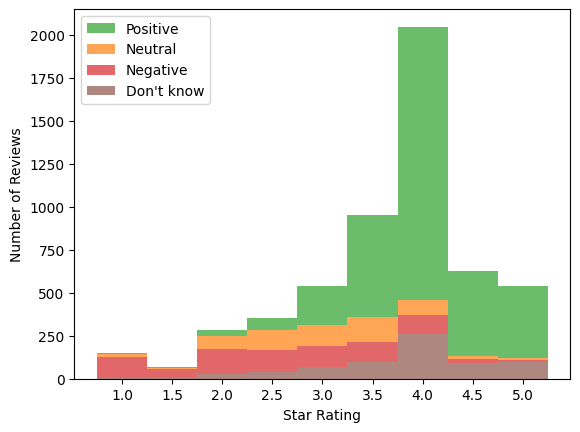

In [6]:
#| echo: false 
#| fig-cap: "Price-sentiment histograms across star-rating"
#| label: fig-sentiment-histogram
import numpy as np
import matplotlib.pyplot as plt
reviews = list(df_new['reviews'])
sentiments = list(df_new['sentiment'])

sentimentDict = {'Positive': 0, 'Neutral': 1, 'Negative': 2, "Don't know": 3}
targetDict = dict(zip(sentimentDict.values(), sentimentDict.keys()))

labels = np.array([sentimentDict[s] for s in sentiments])
df_new['labels'] = df_new['sentiment'].apply(lambda x: sentimentDict[x])

x = [df_new[df_new['labels']==i]['rating'] for i in range(4)][::-1]
labels = list(targetDict.values())[0:4][::-1]
colors = {'Positive': '#2ca02c', 'Neutral': '#ff7f0e', 'Negative': '#d62728', "Don't know": '#8c564b'}
color_list = [colors[label] for label in labels]
bins = np.arange(0.5, 5.5, 0.5)+0.25

fig = plt.figure()
ax = fig.add_subplot()
h = ax.hist(x, bins=bins, label = labels, color=color_list, alpha=0.7, stacked=True)
plt.xticks(np.arange(1,5.5, 0.5))
#plt.ylim(0,1)
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
plt.show()

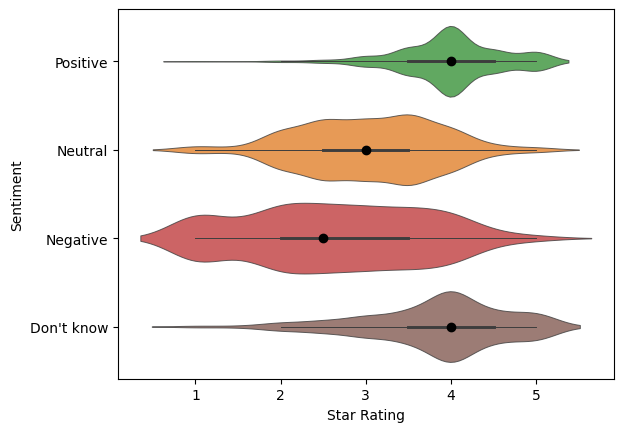

In [7]:
#| echo: false 
#| fig-cap: "Price-sentiment violin plots across star-rating"
#| label: fig-sentiment-violinplot
import seaborn as sns

ax = sns.violinplot(data=df_new.sort_values('rating'), 
                    x='rating', 
                    y='sentiment', 
                    palette=colors, 
                    scale = "width", 
                    order = colors.keys(), 
                    linewidth=0.7,
                    bw=0.31, 
                    #cut=1
)
plt.setp(ax.collections, alpha=0.8)

means = df_new.groupby('sentiment')['rating'].mean().reindex(colors.keys())
modes = df_new.groupby('sentiment')['rating'].agg(lambda x: pd.Series.mode(x)[0]).reindex(colors.keys())
median = df_new.groupby('sentiment')['rating'].median().reindex(colors.keys())
plt.scatter(x=median,y=list(range(len(median))),c='k', zorder=10)

plt.xlabel('Star Rating')
plt.ylabel('Sentiment')
plt.show()

Its no surprise that price-sentiments and star ratings are correlated. It is surprising to see the neutral sentiments resting distinctly between 2- and 4-stars with small tails. This supports the neutral category being a real third category in sentiment analysis, and it is nearly equal in proportion to the negative sentiments. 

Selecting 1- and 5-star reviews as proxies for negative and positive sentiment appears reasonable after considering the relative contributions from each sentiment per rating. The ratio of positive-to-negative sentiments above 4.5 stars is 26-to-1. The ratio of negative-to-positive sentiments below 1.5 stars is 14-to-1. This suggests approximating the price-sentiment with the star rating may be viable. 

The figure below shows "Don't know" sentiments lean towards higher star-ratings. This suggests there may be more "Don't knows" will be falsely predicted as positive than negative. This is a better than the opposite considering how the neutral and negative sentiments are a minority class. 

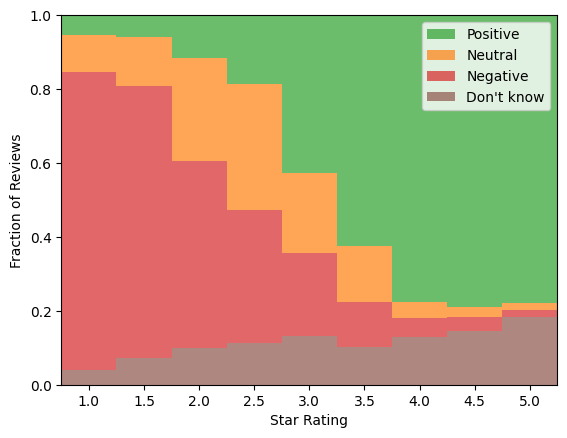

In [9]:
#| echo: false 
#| output: true
fig = plt.figure()
ax = fig.add_subplot()

h2 = np.append([h[0][0]], np.diff(h[0],  axis=0), axis=0)

binWidth = np.diff(h[1])[0]
binsCentered = h[1][1:]-binWidth*0.5

barsTotal = sum(h2)
bars = np.array([h2[i]/barsTotal for i in range(4)])

for i in range(4):
    plt.bar(binsCentered, bars[i], bottom = sum(bars[0:i]), width = binWidth, color = color_list[i], alpha=0.7, label = labels[i])
    
ax.legend(handles[::-1], labels[::-1])
plt.ylim(0,1)
plt.xlim(0.75,5.25)
plt.xlabel('Star Rating')
plt.ylabel('Fraction of Reviews')
plt.show()

In [9]:
#| echo: false 
p1 = len(df_new[(df_new['sentiment']=='Positive') & (df_new['rating']<=1.5)])
p5 = len(df_new[(df_new['sentiment']=='Positive') & (df_new['rating']>=4.5)])
n1 = len(df_new[(df_new['sentiment']=='Negative') & (df_new['rating']<=1.5)])
n5 = len(df_new[(df_new['sentiment']=='Negative') & (df_new['rating']>=4.5)])
#print(p1,p5,n1,n5)
#print(n1/p1, p5/n5)

## Partisan Sentiment! Neutral is negative

After running a couple experiments, it became immediately clear that most neutral sentiments are falsely classified as positive or negative. This is because distinguishing "not bad" from "good" requires a lot more samples to capture context and language [^1]. I decided to combine the neutral and negative categories as negative because:

- I am less likely to purchase a bottle considered "not bad", let alone a bottle that is "not good". This is my bias.
- The neutral and negative categories generally overlap with respect to star-ratings. 
- The pool of negative sentiment data is doubled.
- Eliminating a category eliminates a set of potential false classifications. 

# 4: Define A Metric

The "best" model requires (A) definitions of success, (B) models to compare to, and (C) costs or economics of running these models (i.e., do I need a supercomputer?). Models also have a shelf-life because the environment is not static (e.g., culture, technologies, and needs change). Your model may create feedback and change the dynamic of the environment too. For instance, if you modelled the stock market and made a ton of money, your influence affects stocks and will eventually weaken your original model.  

Let's define the nature of our product and understand what would be a successful outcome from a model. 

#### Product goals:

The current deliverable is a recommendation scale. As stated in the introduction, the number of positive and negative sentiments (conditional on price) generates the following sentiment-ratio to the user:

1. **56 out of 61 recommend this price!**
2. **7 out of 10 recommend this price!**

Misclassifying a "7 out of 10" (truth) as a "6 out of 10" (model) by 10% may be sufficient to dissuade a customer. Likewise, a customer may decide to buy a bottle with a falsely higher sentiment-ratio. Therefore, the positive and negative categories are both important to get right. **We value both precision and recall for both categories.**

The "Don't knows" (DKs) are often neglected in these types of analyses. DKs effectively act as noise burying our desired signal. Noise can act unfairly and bias results to ultimately degrade a product's quality. Fortunately, the work creating our training set reveals DKs to be the smallest proportion of reviews with 13%. Negatives (merged with neutrals) are 26% and the remaining are positive sentiments. **A reduction in true DKs (i.e., high recall) is a plus** since we want to minimize noise from our reviews. 

I do not care about the precision of DKs since those are discarded. Mislabelling positive or negative sentiments is serious since we do not want to throw out reviews and reduce our pool of recommended bottles. But, this emphasizes the value of positive and negative recall and not the precision of DKs.

The F-score is a harmonic mean of recall and precision with an added real positive coefficient $\beta$ that acts as a weight. Equal importance is applied to recall and precision when $\beta=1$. 

- We want to use an F1-score for both the positive and negative sentiments since precision and recall are valuable in the recommender.
- Only recall is important for the DKs since we want to minimize noise. (i.e., $\beta\rightarrow\infty$).

I choose the following weighted score to compare between models:
$$
\mathrm{Weighted\ Score} = \frac{F_1(\mathrm{Positive}) + F_1(\mathrm{Negative}) + C_{\mathrm{DK}}R(\mathrm{Don't\ know})}{2 + C_{\mathrm{DK}}}
$$
where $F_1$ is the F1-score and $R(\mathrm{Don't\  know})$ is the recall of DKs. The positive and negative categories are weighted equally (rather than by frequency) due to their equal importance in the recommender. DK's weight, $C_{\mathrm{DK}}=0.13$, remains equal to its frequency since the model should emphasize on discriminating the signal. 

The custom scorer is defined below which I'll use in a grid search. 


In [182]:
#| code-summary: "Code: Weighted scorer"
import numpy as np
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

def weightedScore(y_true, y_pred, encoder=None):
    if encoder:
        classes = encoder.classes_
        labels = list(range(len(classes)))
    else:
        classes = ["Don't know", 'Negative', 'Positive']
        labels = classes
    
    f1 = f1_score(y_true, y_pred, labels = labels, average=None)
    recall = recall_score(y_true, y_pred, labels = labels, average=None)
    f1Dict = dict(zip(classes, f1))
    recallDict = dict(zip(classes, recall))
    
    scoreVector = np.array([f1Dict['Positive'], f1Dict['Negative'], recallDict["Don't know"]])
    weightsVector = np.array([1, 1, freqDict["Don't know"]])
    score = np.dot(scoreVector, weightsVector) / np.sum(weightsVector)
    
    return score

sentimentScorer = make_scorer(weightedScore, greater_is_better = True)

# 5: Feature Engineering

Before diving into the reasoning, here is my approach to engineering features for the data I'll train on.

1. Star rating: No processing.
2. Bag of Words: Quantify significance of terms using TF-IDF.
3. Sentence-Transformers: Extract meaning or intent underlying the text.


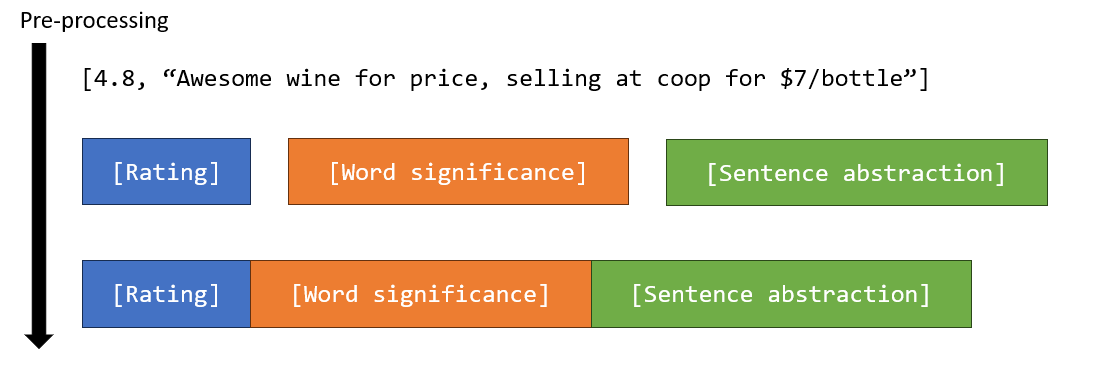

## NLP Strategies

My price-sentiment labels capture two different ideas:

- The sentiment for a price: Positive vs. Negative
- The existence of a sentiment: "Don't know" vs. (Positive or Negative)

A popular sentiment analysis strategy is the bag-of-words model. In short, a document is disassociated into a list of words and the context for those words are destroyed. A machine learning model then delineates words (features) that correspond to a document's label. The values for these features represent the count or some measure of significance (e.g., TF-IDF). 

Price-sentiment typically relies on a few words and more strongly on context. For instance, here are two real reviews with and without price-sentiment:

- [Positive] "Awesome wine for price, selling at coop for $7/bottle" 
- [Don't know] "Great smell and taste $62 at Binnys with 5% off, might have been on sale"

Here are the versions without stopwords: 

- awesome, price, selling, coop, $7/bottle
- great, smell, taste, $62, binnys, 5%, off, might, been, on, sale

Identifying price-sentiment (or lack thereof) requires context. That's where Sentence Transformers (STs) shine. STs are trained on an enormous corpus of text to learn the intent and meaning behind sentences. Very minimal pre-processing is required before transforming a sentence. There are setbacks that may prevent you from using STs, however. Here is a list of ST nuances and their relevance for wine reviews:

- **Input length**: STs commonly have 512 token limits which roughly corresponds to 300-400 English words. Longer documents will be truncated unless they are broken into pages, paragraphs, or sometimes sentences. Wine reviews have a 520-character limit or approximately 100 words (see this [figure](../2023-07-06-vivino-part1/#fig-words)), so this is not an issue.

- **Training data**: The ST model is trained on an [enormous corpus](https://huggingface.co/sentence-transformers/all-roberta-large-v1) of text data. It will perform better if your text data is similar to ST's training data. The good news is that you can fine-tune an ST model to learn your your text's domain knowledge (e.g., astrophysics)! More on this to come. 

- **GPU**: A GPU can decrease the computational time to transform a sentence by one to two orders of magnitude compared to a CPU. If you have a large set of data, this can be an expensive step without a GPU! 

- **Context** Unlike bag of words, STs are designed to capture the context surrounding words as well. STs attempt to capture the intention or meaning in a sentence. Thus, the output vectors are "sentence" embeddings rather than an array of "word" embeddings generated from a vectorizer. Steps 1-5 from the bag of words procedure are **collapsed into one step**! Some pre-processing with punctuation might be, however (e.g., a wall of emojis is probably difficult to interpret).  



## Sentence Embedding with [S-BERT](https://www.sbert.net/)

#### Import sentence-transformer

After installing [sentence-transformers](https://www.sbert.net/), [select an embedding model](https://www.sbert.net/docs/pretrained_models.html) and download it automatically using the code below. Here, I show what typical values the embedding vectors take on.

In [11]:
#| code-summary: "Code: sentence-transformer"
#| code-fold: show
from sentence_transformers import SentenceTransformer

embeddingModelName = "all-MiniLM-L6-v2"
sentenceModel = SentenceTransformer(embeddingModelName)
outputDim = sentenceModel.get_sentence_embedding_dimension()
print(f"Number of embedding dimensions: {outputDim}")

text = [
    "I love plants!",
    "More wine. Give me more! This wine is amazing for $500",
    "It is possible to commit no mistakes and still lose. That is not a weakness. That is life.",
    "I love sentence embeddings. We need more."
]
textEmbeddings = sentenceModel.encode(text, normalize_embeddings = True)

Number of embedding dimensions: 384


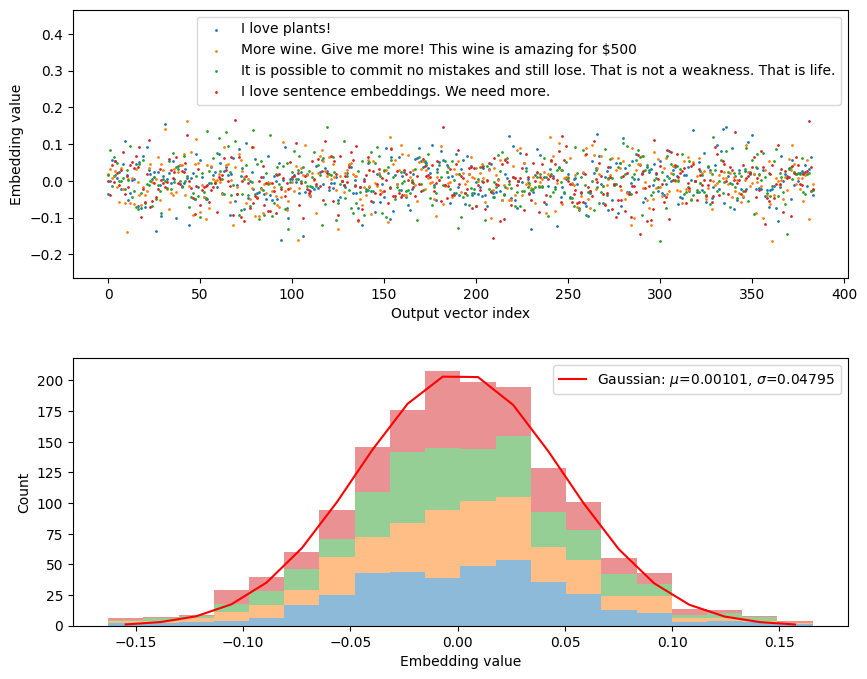

In [12]:
#| code-summary: "Code: plot embedding vectors"
#| code-fold: true

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def gaussian(x, mu, sigma, a):
    return a*np.exp(-0.5*(x-mu)**2/sigma**2)

# Figures:
fig,(ax1,ax2) = plt.subplots(2)
fig.set_size_inches(10,8)
# Subplot 1: scatter plot of embeddings
for i, embedding in enumerate(textEmbeddings):
    ax1.scatter(list(range(outputDim)), embedding, s = 1, label=text[i])
ax1.set(xlabel="Output vector index", ylabel='Embedding value')
ax1.legend()
ax1.set_ylim(np.min(textEmbeddings)-0.1, np.max(textEmbeddings) + 0.3)

# Subplot 2: histogram of values and a gaussian fit.
textEmbeddings = [t for t in textEmbeddings] # Funny pixel tv without.
h = ax2.hist(textEmbeddings, bins=20, alpha=0.5, stacked=True)
xdata = h[1][1:] - 0.5*np.diff(h[1])[0] # get center from bin edges.
ydata = h[0][-1]

popt, pcov = curve_fit(gaussian, xdata, ydata, p0=(0, 0.3, 100))
SIGMA_ST = popt[1]
ax2.plot(xdata, gaussian(xdata, *popt), 
         'r-', 
         label=r'Gaussian: $\mu$=%5.5f, $\sigma$=%5.5f' % tuple(np.abs(popt[0:2])))
ax2.set(xlabel='Embedding value', ylabel = 'Count')

plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.show()

The normalized embedding vectors look quite Gaussian. 

Here's an example of calculating the cosine similarities for each combination of sentence embeddings. There are four wine reviews with positive and negative price sentiments. There is also one quote from Picard, which is clearly dissimilar to the wine reviews. 

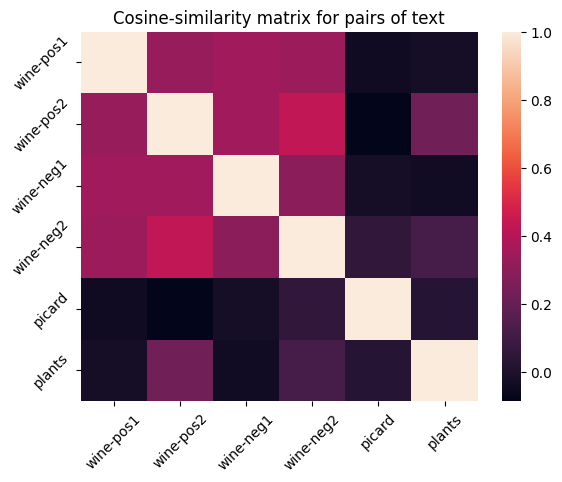

Tick Label    Text
------------  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
wine-pos1     Great value cab - locally $10.50
wine-pos2     A dark berry nose and deep berry flavor on the top. Blackberries it tells me. A blend that defies the pricing at under $20. A robust hit of smoky oak with a decent finish not usually found in this price range! Can you tell I like it?
wine-neg1     A little lighter than expected, not in a good way. $16 is apparently overpriced. Would not seek out.
wine-neg2     Actually not a bad wine but for the $56 we paid for it i can think of many more better wines. Nice after taste but dry.
picard        It is possible to commit no mistakes and still lose. That is not a weakness. That is life.
plants        I love plants!

In [13]:
#| echo: false
#| tbl-colwidths: [20,80]
text_sample = [
    "Great value cab - locally $10.50",
    "A dark berry nose and deep berry flavor on the top. Blackberries it tells me. A blend that defies the pricing at under $20. A robust hit of smoky oak with a decent finish not usually found in this price range! Can you tell I like it?",
    "A little lighter than expected, not in a good way. $16 is apparently overpriced. Would not seek out.",
    "Actually not a bad wine but for the $56 we paid for it i can think of many more better wines. Nice after taste but dry.",
    "It is possible to commit no mistakes and still lose. That is not a weakness. That is life.",
    "I love plants!"
]
textEmbeddings = sentenceModel.encode(text_sample, normalize_embeddings = True)

sns.heatmap(np.tensordot(textEmbeddings,textEmbeddings.T, axes=1), vmax=1)
ticklabels = ['wine-pos1','wine-pos2','wine-neg1', 'wine-neg2', 'picard', 'plants']
plt.xticks(rotation=45,ticks=list(np.arange(0.5,len(ticklabels)+0.5,1)), labels=ticklabels)
plt.yticks(rotation=45,ticks=list(np.arange(0.5,len(ticklabels)+0.5,1)), labels=ticklabels)
plt.title('Cosine-similarity matrix for pairs of text')
plt.show()
Markdown(tabulate(
  list(zip(ticklabels,  text_sample)), 
  headers=[ "Tick Label", "Text" ]
))